### 0.0 Libraries and Functions

In [155]:
import math
import pickle
import random
import datetime
import warnings
import inflection
import numpy               as np
import pandas              as pd
import seaborn             as sns
import xgboost             as xgb
import matplotlib.pyplot   as plt

from flask                 import Flask
from scipy                 import stats
from boruta                import BorutaPy
from tabulate              import tabulate
from dython.nominal        import associations
from IPython.display       import Image
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from matplotlib.gridspec   import GridSpec
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings('ignore')

#### 0.1 Helper Functions

In [55]:
# Função para realizar as médias das previsões do modelo de ML
def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

# Ajuste de tamanho para os gráficos criados
sns.set(rc={'figure.figsize':(12, 10)})

# Atalho para o uso das funções das bibliotecas de ajuste estatístico
rs = RobustScaler()
mms = MinMaxScaler()
le = LabelEncoder()


# Cramer's V -> fórmula para se medir a correlação de variáveis categóricas simetricamente
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


# Theil's U -> fórmula para se medir a correlação de variáveis categóricas simetricamente
def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x
    
# Função de aplicação do Cross Validation
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('KFold Number: {}'.format(k))

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)            
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']
        
        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold interation
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': round(np.mean(mae_list), 2).astype(str) + ' +/- ' + round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': round(np.mean(mape_list), 2).astype(str) + ' +/- ' + round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + round(np.std(rmse_list), 2).astype(str)}, index=[0])

#### 0.2 Loading Data

In [56]:
df_sales_raw = pd.read_csv('csv_files/train.csv', low_memory=False)
df_store_raw = pd.read_csv('csv_files/store.csv', low_memory=False)

# Merging
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

### 1.0 Data Description

#### 1.1 Rename Columns

In [57]:
df1 = df_raw.copy()

In [58]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

#### 1.2 Data Dimensions

In [59]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   date                          1017209 non-null  object 
 3   sales                         1017209 non-null  int64  
 4   customers                     1017209 non-null  int64  
 5   open                          1017209 non-null  int64  
 6   promo                         1017209 non-null  int64  
 7   state_holiday                 1017209 non-null  object 
 8   school_holiday                1017209 non-null  int64  
 9   store_type                    1017209 non-null  object 
 10  assortment                    1017209 non-null  object 
 11  competition_distance          1014567 non-null  float64
 12  competition_open_since_month

#### 1.3 Data Types

In [60]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

#### 1.4 Check NA

In [61]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

#### 1.5 Fill NA

In [62]:
#competition_distance -> filling the dataset with a high distance value
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [63]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

#### 1.6 Change Types

In [64]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [65]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

#### 1.7 Descriptive Statistical

In [66]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


In [67]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.7.1 Numerical Attributes

In [68]:
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
d3 = pd.concat([d1, d2]).T.reset_index()
d3.columns = ['attributes', 'skew', 'kurtosis']
d3

,attributes,skew,kurtosis
0,store,-0.000955,-1.200524
1,day_of_week,0.001593,-1.246873
2,sales,0.641460,1.778375
3,customers,1.598650,7.091773
4,open,-1.758045,1.090723
5,promo,0.487838,-1.762018
6,school_holiday,1.677842,0.815154
7,competition_distance,10.242344,147.789712
8,competition_open_since_month,-0.042076,-1.232607
9,competition_open_since_year,-7.235657,124.071304


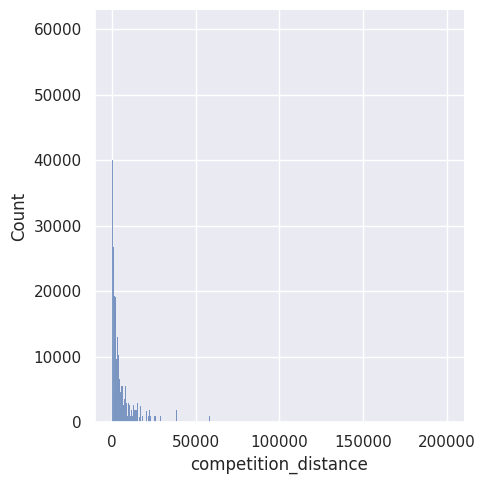

In [69]:
sns.displot(df1['competition_distance'])

#### 1.7.2 Categorical Attributes

<AxesSubplot: xlabel='assortment', ylabel='sales'>

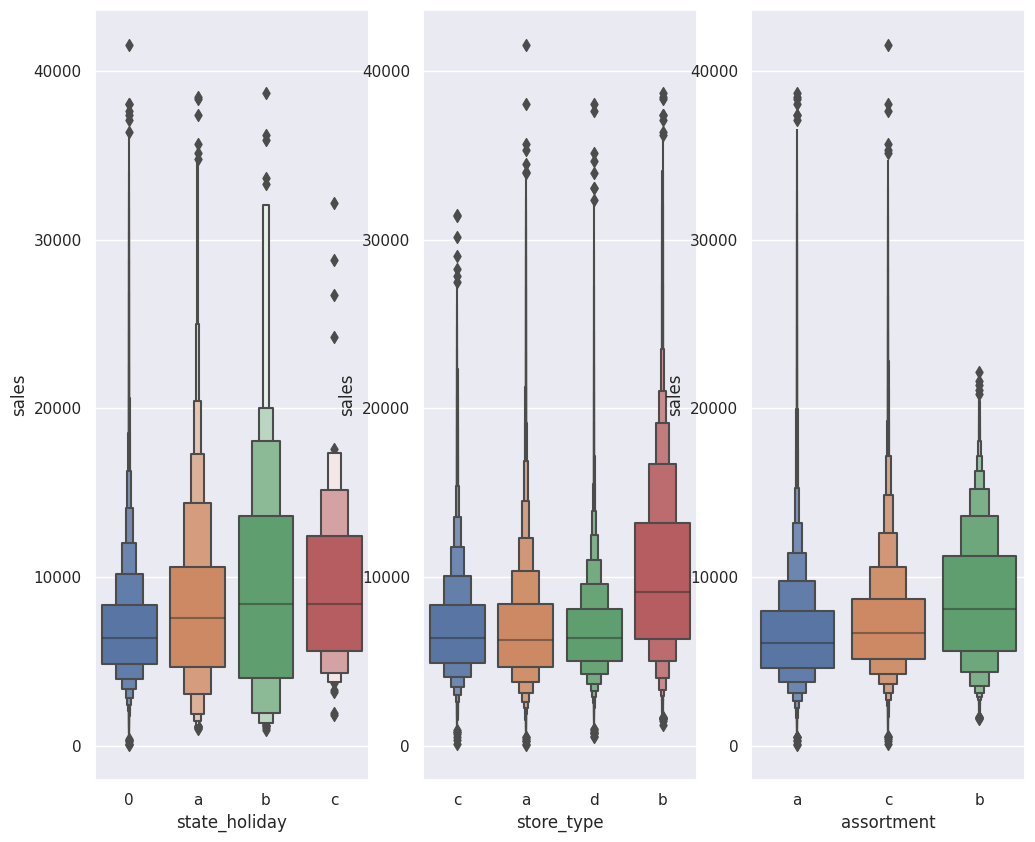

In [70]:
#sns.set(rc={'figure.figsize':(15, 10)})
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0 )]

plt.subplot(1, 3, 1)
sns.boxenplot(x='state_holiday' , y='sales' , data=aux1 )

plt.subplot(1, 3, 2)
sns.boxenplot(x='store_type' , y='sales' , data=aux1 )

plt.subplot(1, 3, 3)
sns.boxenplot(x='assortment' , y='sales' , data=aux1 )

### 2.0 Feature Engineering

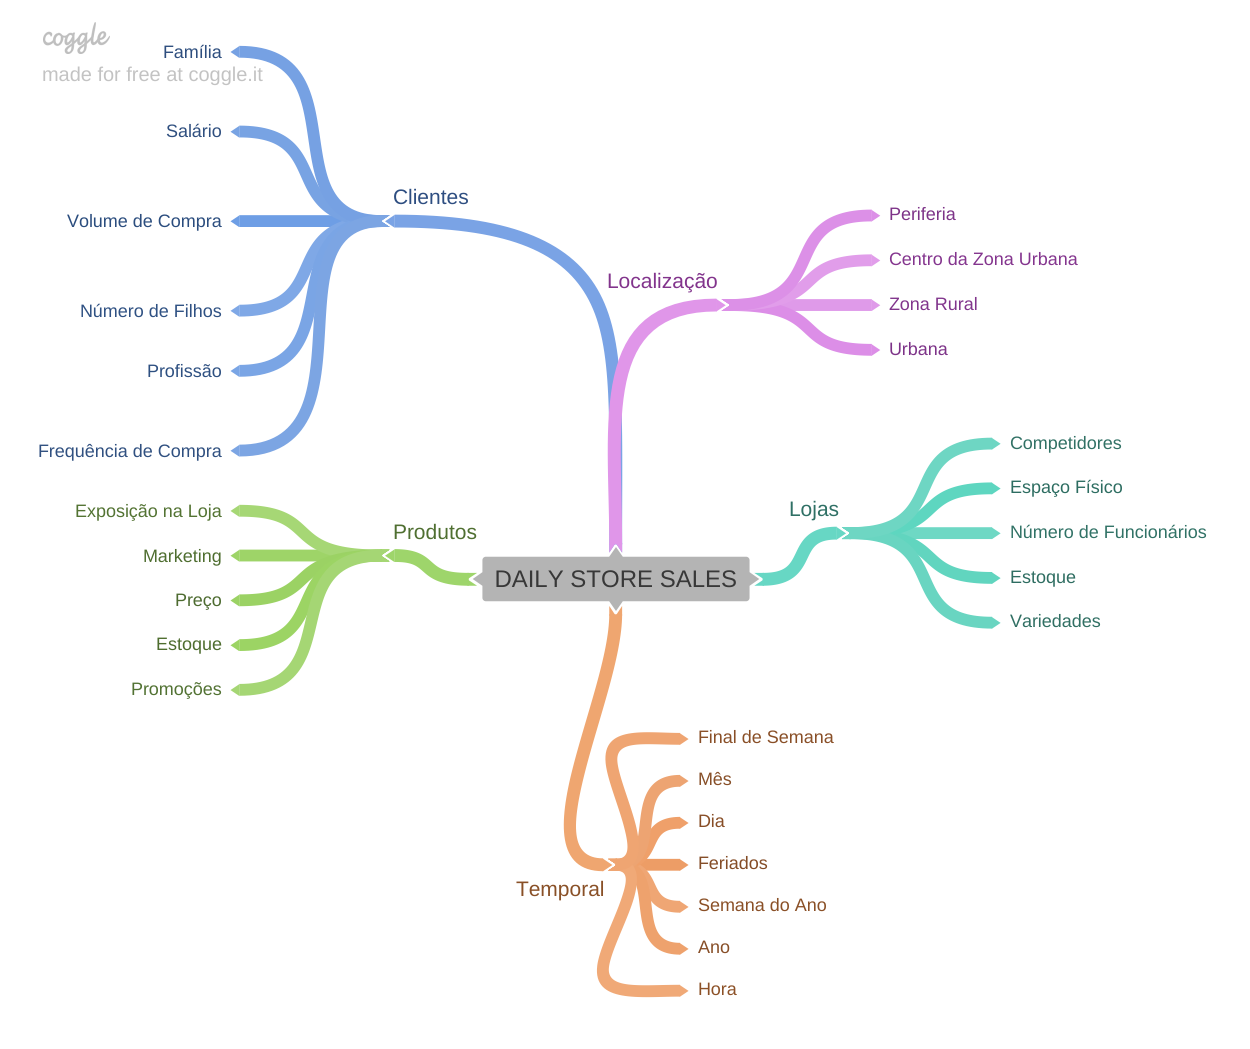

In [71]:
Image('img/mind_map_hypthesis.png')

#### 2.1 Hypothesis

1. Lojas com maior sortimentos vendem mais?
2. Lojas com competidores mais próximos vendem menos?
3. Lojas com competidores há mais tempo vendem mais?
4. Lojas com promoções ativas por mais tempo vendem mais?
5. Lojas com promoções consecutivas vendem mais?
6. Lojas abertas durante o feriado do Natal vendem mais?
7. As lojas estão vendendo mais ao longo dos anos?
8. Lojas vendem mais nos finais de semana?
10. Lojas vendem mais depois do 10º dia do mês?

#### 2.2 Feature Engineering

In [72]:
df2 = df1.copy()

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1), axis=1)    
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days= 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [73]:
df2.sample(5).T

,759044,91805,1005451,617747,955335
store,515,376,507,823,566
day_of_week,2,7,5,3,1
date,2013-08-20 00:00:00,2015-05-10 00:00:00,2013-01-11 00:00:00,2013-12-25 00:00:00,2013-02-25 00:00:00
sales,6230,0,10198,0,3481
customers,571,0,756,0,467
open,1,0,1,0,1
promo,0,0,1,0,0
state_holiday,regular_day,regular_day,regular_day,christmas,regular_day
school_holiday,1,0,0,1,0
store_type,d,a,a,a,a


### 3.0 Data Filtering

In [74]:
df3 = df2.copy()

#### 3.1 Row Filtering

In [75]:
df3 = df3[(['open'] != 0) & (df3['sales'] > 0)]

#### 3.2 Column Filtering

In [76]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [77]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

### 4.0 EDA (Exploration Data Analysis)

In [78]:
df4 = df3.copy()

#### 4.1 Univariate Analysis

#### 4.1.1 Response Variable

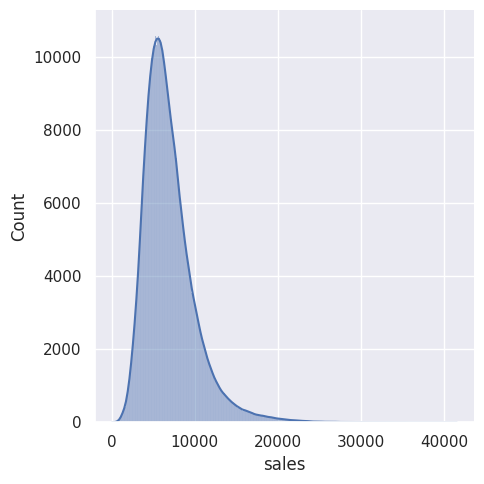

In [79]:
sns.displot(df4['sales'], kde=True)

#### 4.1.2 Numerical Variable

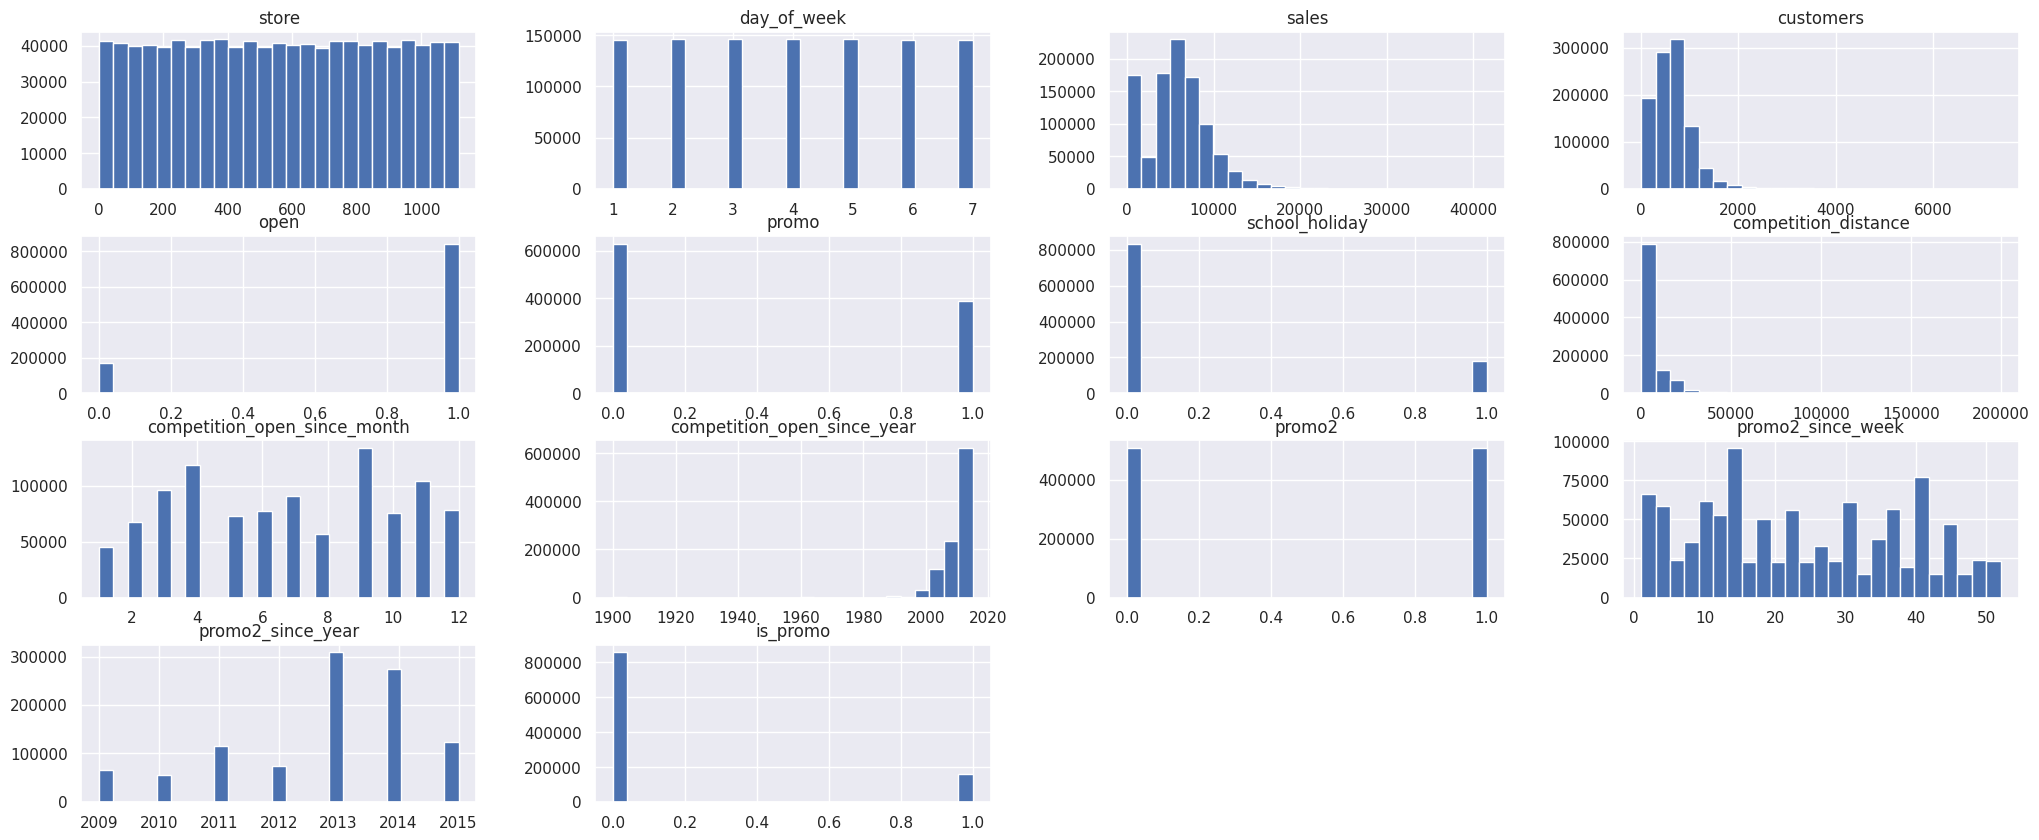

In [80]:
num_attributes.hist(bins=25, figsize=(25, 10));

#### 4.1.3 Categorical Variable

In [81]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

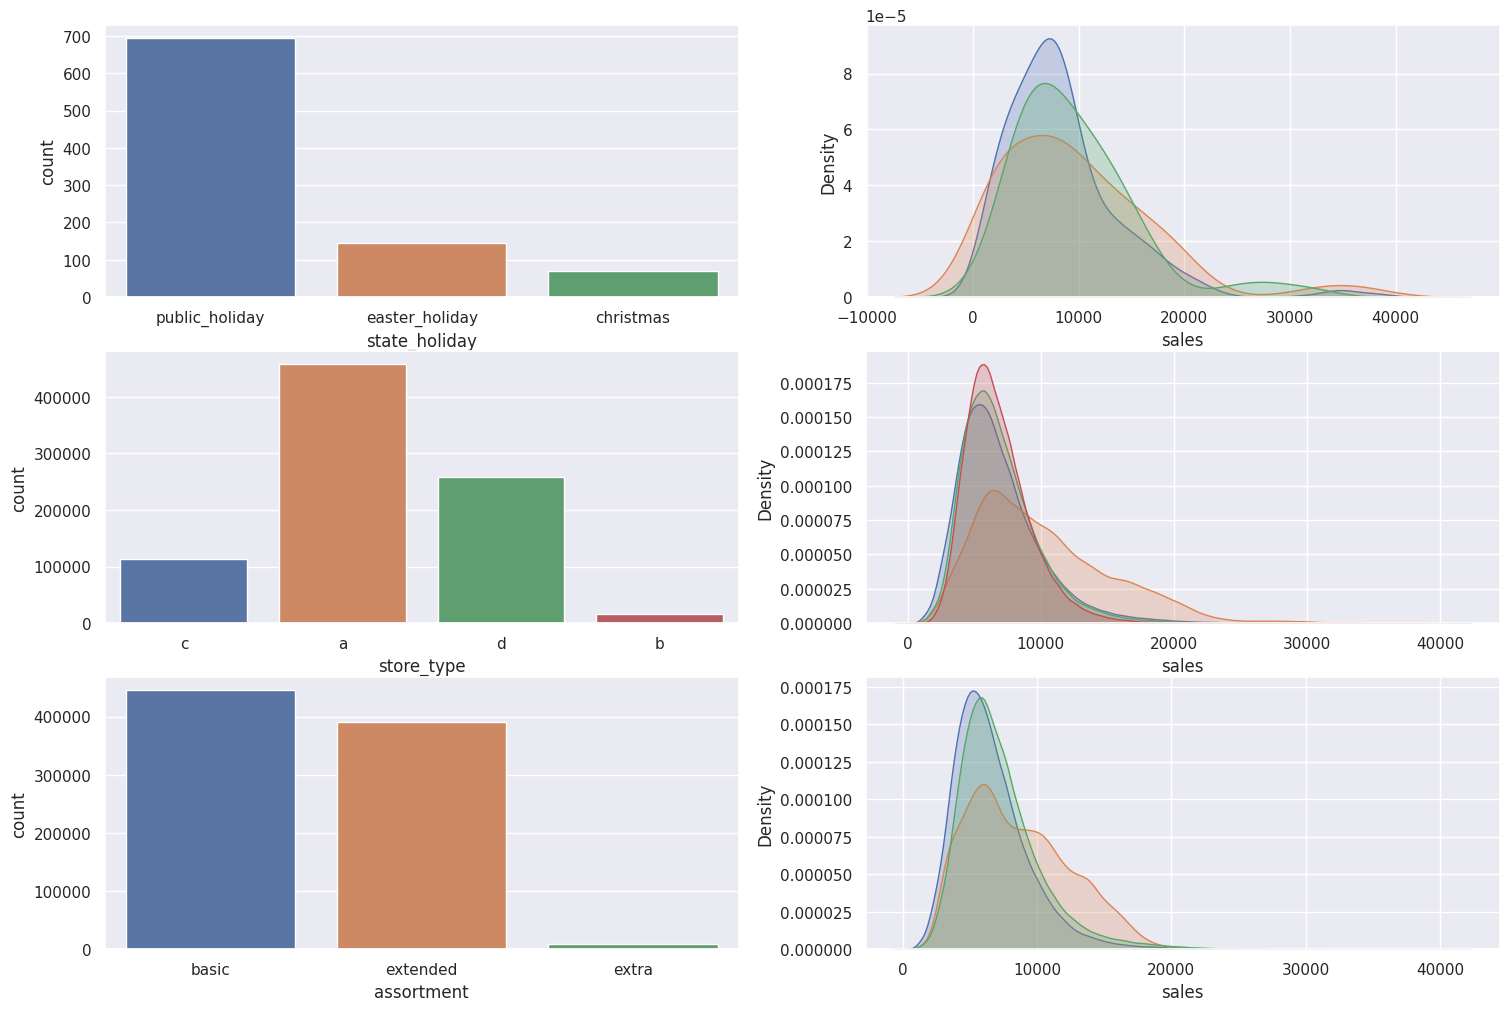

In [82]:
plt.rcParams['figure.figsize']=(18, 12)

# State holiday
plt.subplot(3, 2, 1)
aux = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=aux)

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)

# Store Type
plt.subplot(3, 2, 3)
sns.countplot(data=df4, x= 'store_type')

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(data=df4, x= 'assortment')

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True);

#### 4.2 Bivariate Analysis (Hypothsis)

##### 1. Lojas com maior sortimentos vendem mais?

-> A hipótese é FALSA. As lojas que possuem maior sortimento VENDEM MENOS no geral.

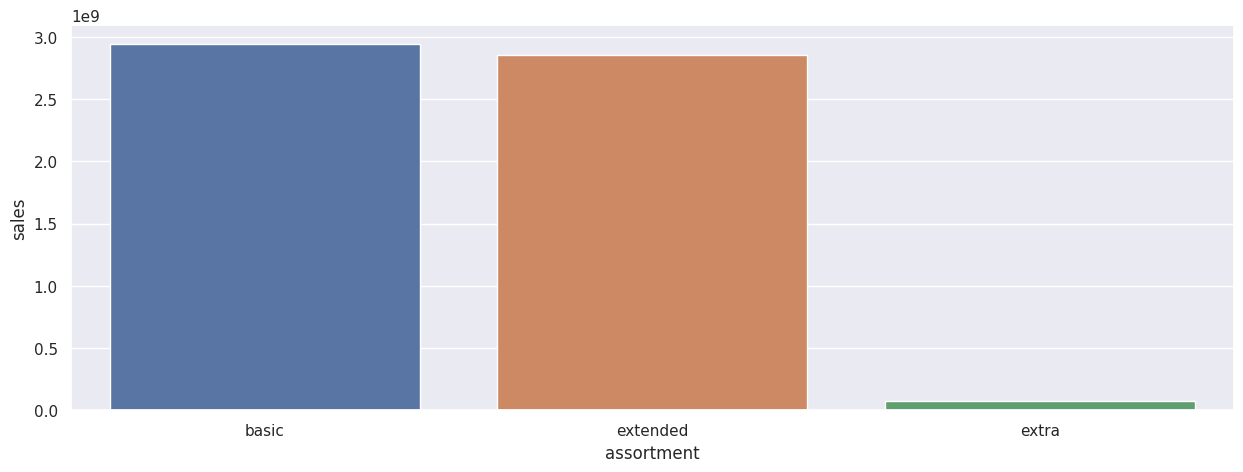

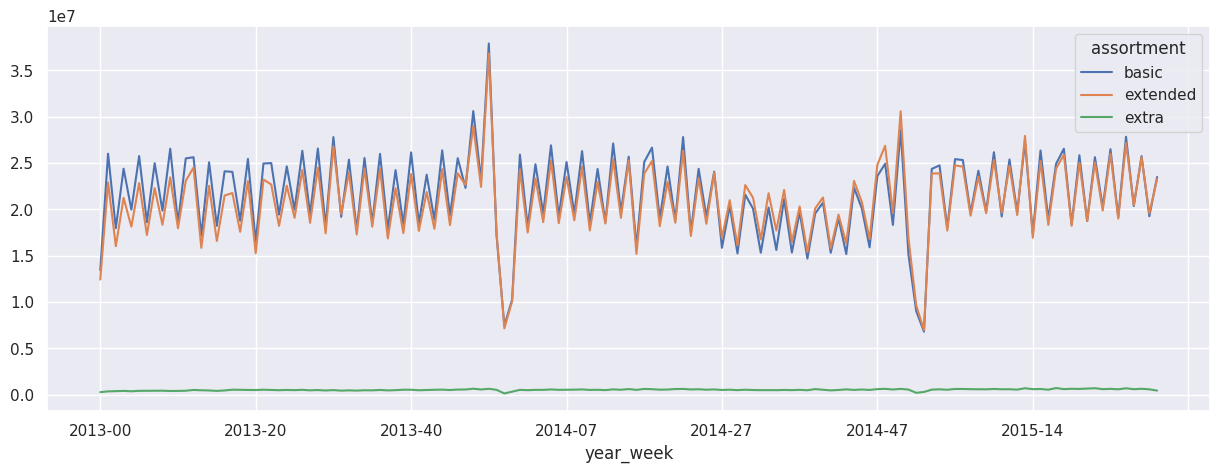

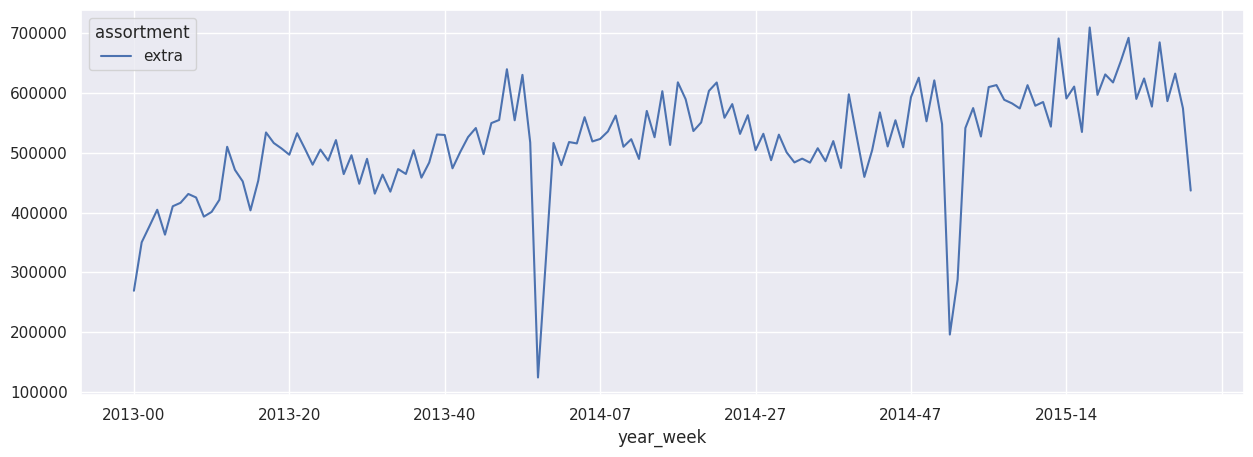

In [83]:
plt.rcParams['figure.figsize']=(15, 5);

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

##### 2. Lojas com competidores mais próximos vendem menos?
-> A hipótese é FALSA. Lojas com COMPETIDORES MAIS PRÓXIMOS VENDEM MAIS.

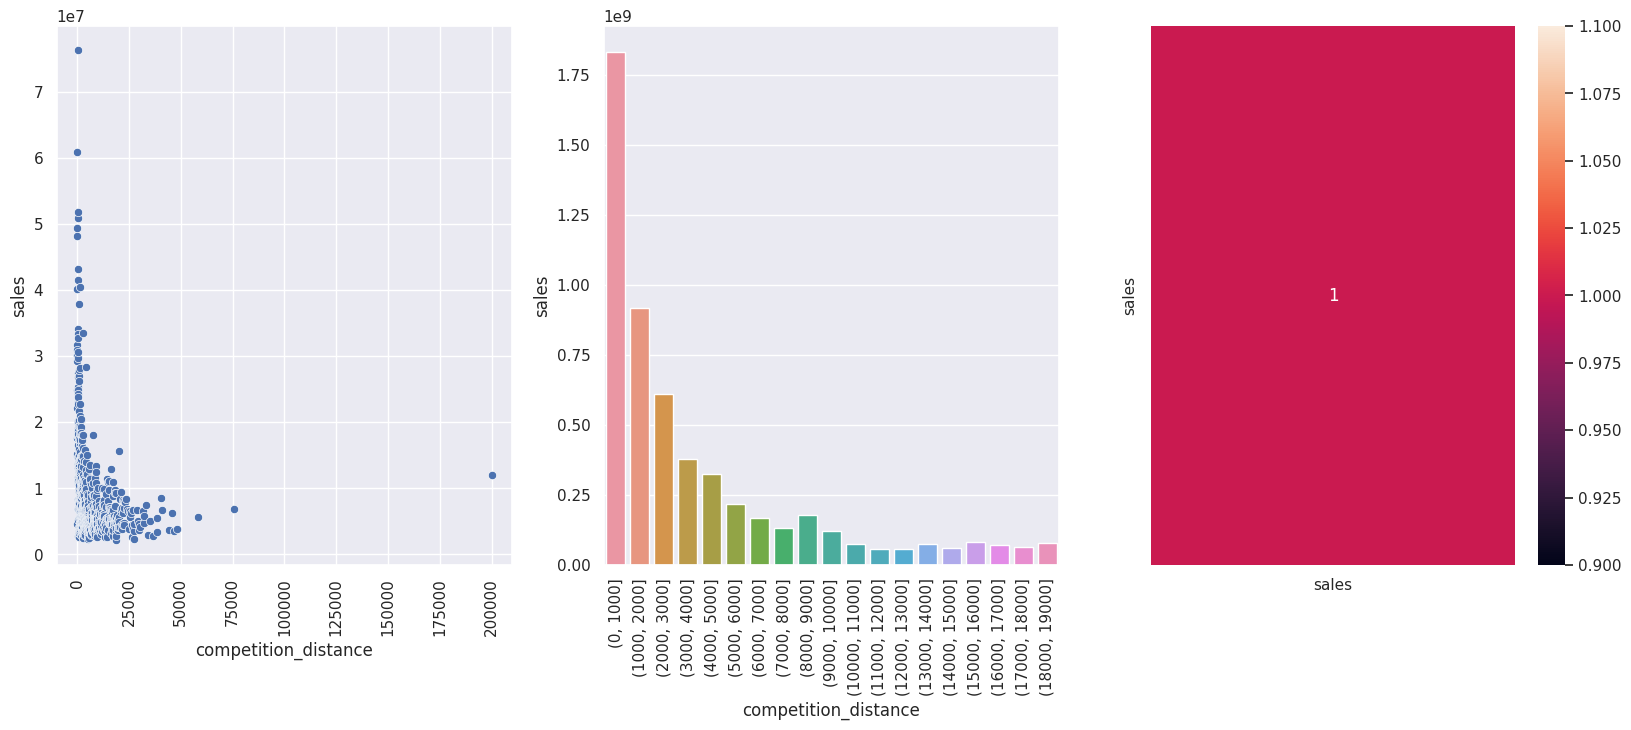

In [84]:
plt.rcParams['figure.figsize']=(20, 7);

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.barplot(x='competition_distance', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### 3. Lojas com competidores há mais tempo vendem mais?
->  A hipótese é FALSA. Lojas com competidores há mais tempo VENDEM MENOS.

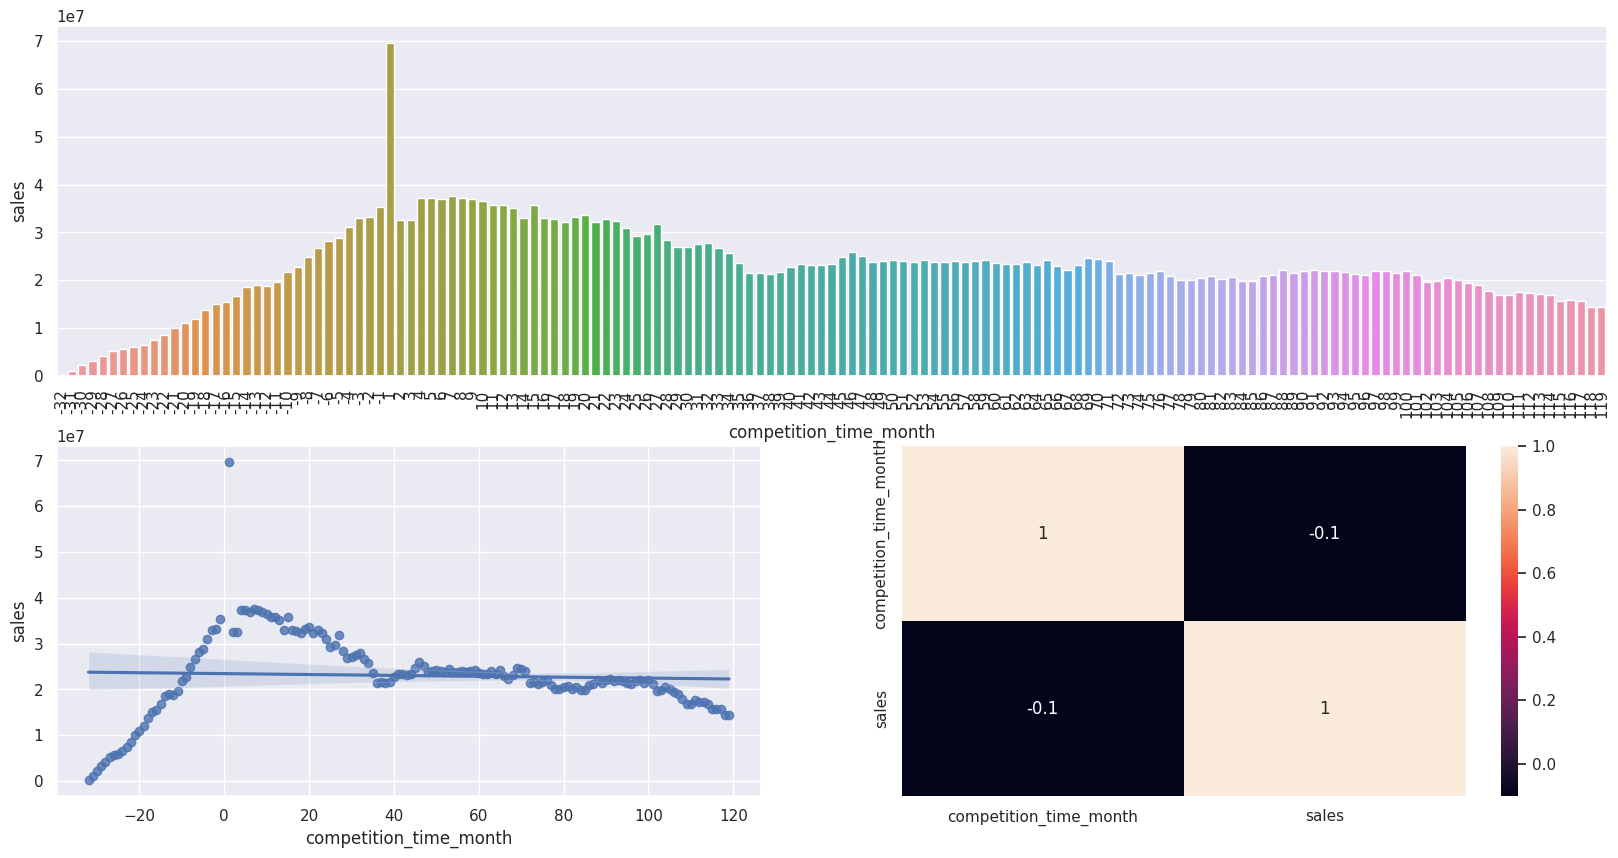

In [85]:
plt.rcParams['figure.figsize']=(20, 10);

# linha, coluna, posição
plt.subplot(2, 1, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(2, 2, 3)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(2, 2, 4)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### 4. Lojas com promoções ativas por mais tempo vendem mais?
-> A hipótese é FALSA. Depois de um certo período de promoção as lojas passam a vender MENOS.

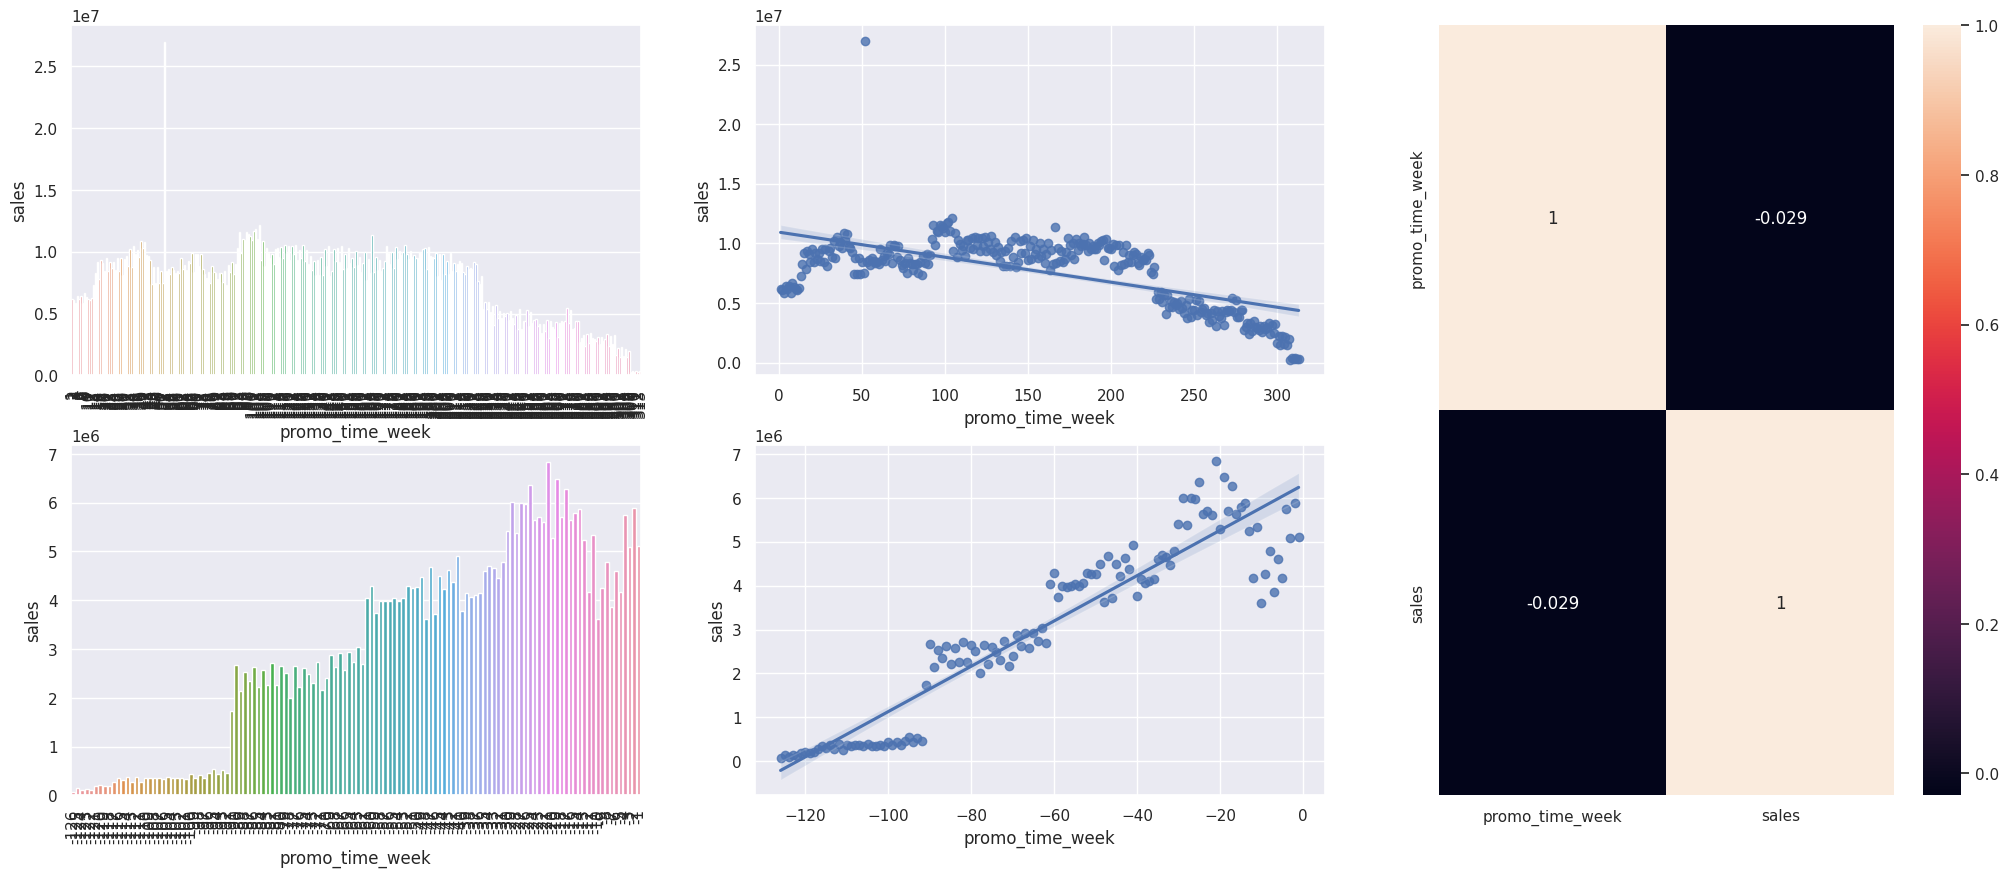

In [86]:
plt.rcParams['figure.figsize']=(25, 10);
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
grid = GridSpec(2,3)

# promo extendido
aux2 = aux1[aux1['promo_time_week'] > 0]
plt.subplot(grid[0,0])
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);
plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

# promo regular
aux3 = aux1[aux1['promo_time_week'] < 0]
plt.subplot(grid[1,0])
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);
plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

# correlação
plt.subplot(grid[2:])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### 5. Lojas com promoções consecutivas vendem mais?
-> A hipótese é FALSA. As lojas com promoções consecutivas vendem MENOS.

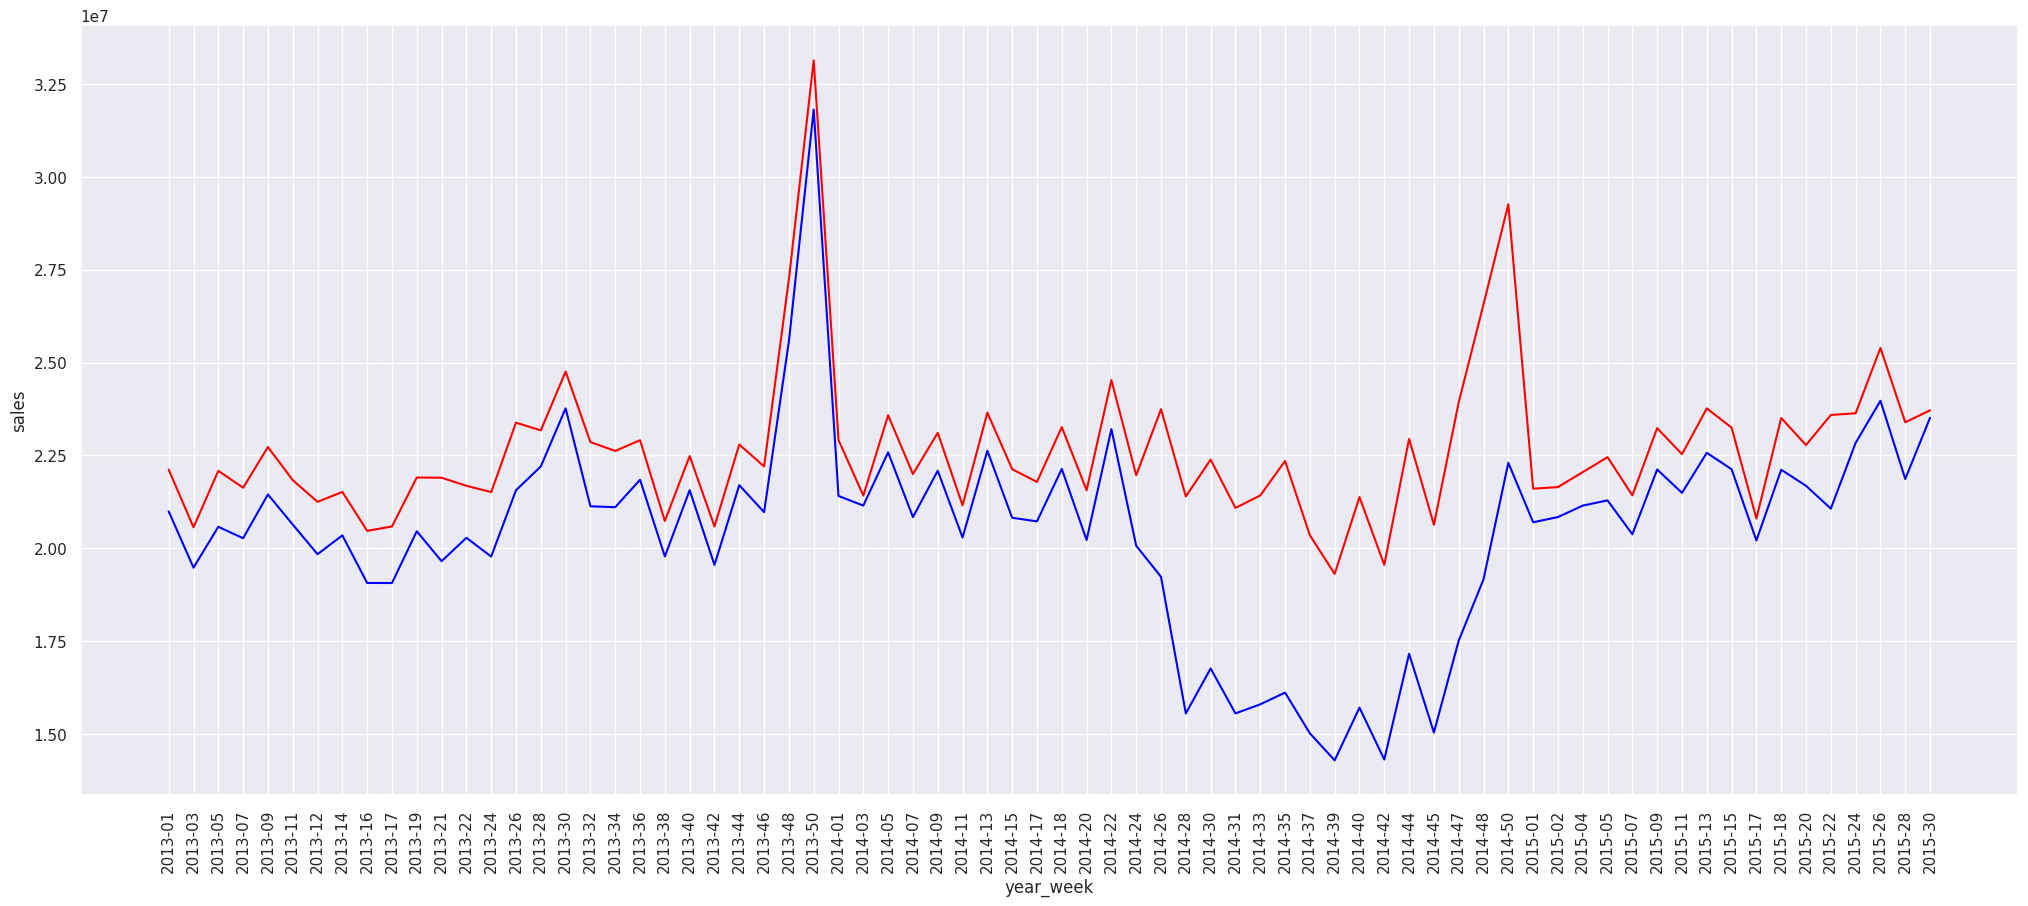

In [87]:
#plt.rcParams['figure.figsize']=(16, 8);
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
#ax = aux1.plot()
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
#aux2.plot(ax=ax)
#ax.legend(labels=['Tradicional e Extendida', 'Extendida']);

fig, ax = plt.subplots()
sns.lineplot(x="year_week", y="sales", color='blue', data=aux1, ax=ax);
sns.lineplot(x="year_week", y="sales", color='red', data=aux2, ax=ax);
plt.xticks(rotation=90);

##### 6. Lojas abertas durante o feriado do Natal vendem mais?
-> A hipótese é FALSA. As lojas abertas durante o feriado do Natal vendem MENOS.

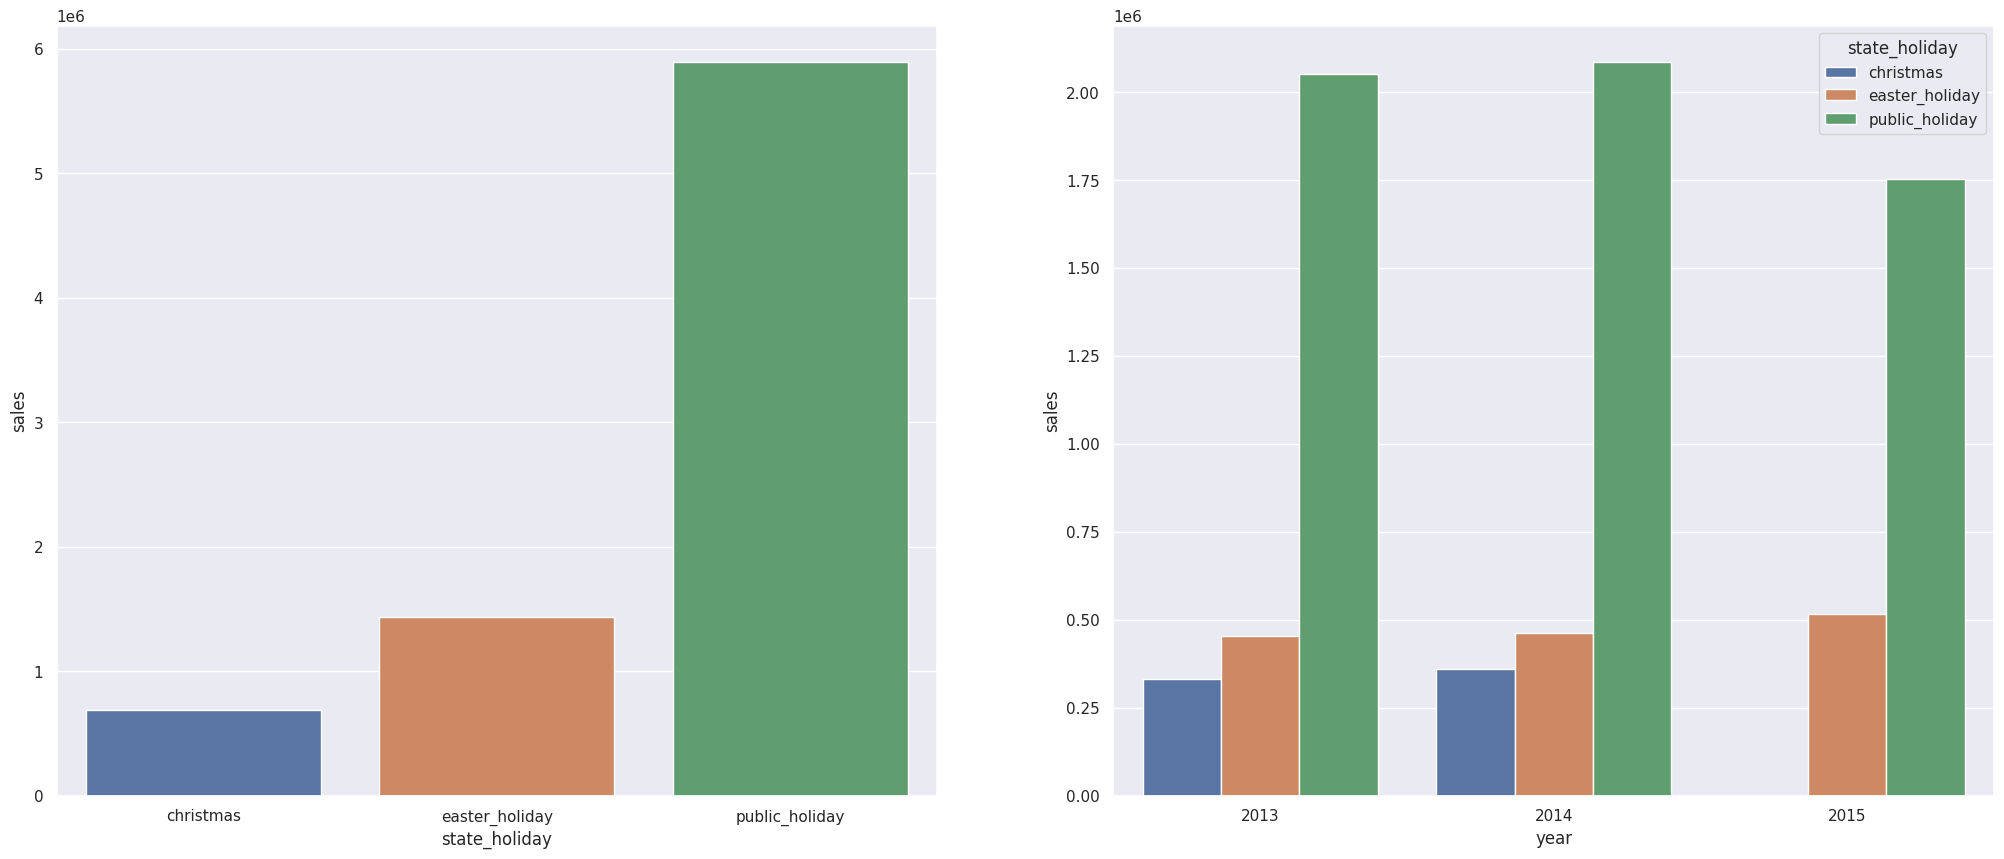

In [88]:
plt.subplot(1, 2, 1)
aux1 = df4[df4['state_holiday'] != 'regular_day'][['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index() 
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = df4[df4['state_holiday'] != 'regular_day'][['state_holiday', 'year', 'sales']].groupby(['state_holiday', 'year']).sum().reset_index() 
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

##### 7. As lojas estão vendendo mais ao longo dos anos?
-> A hipótese é FALSA. As vendas estão diminuindo ao longo dos anos.

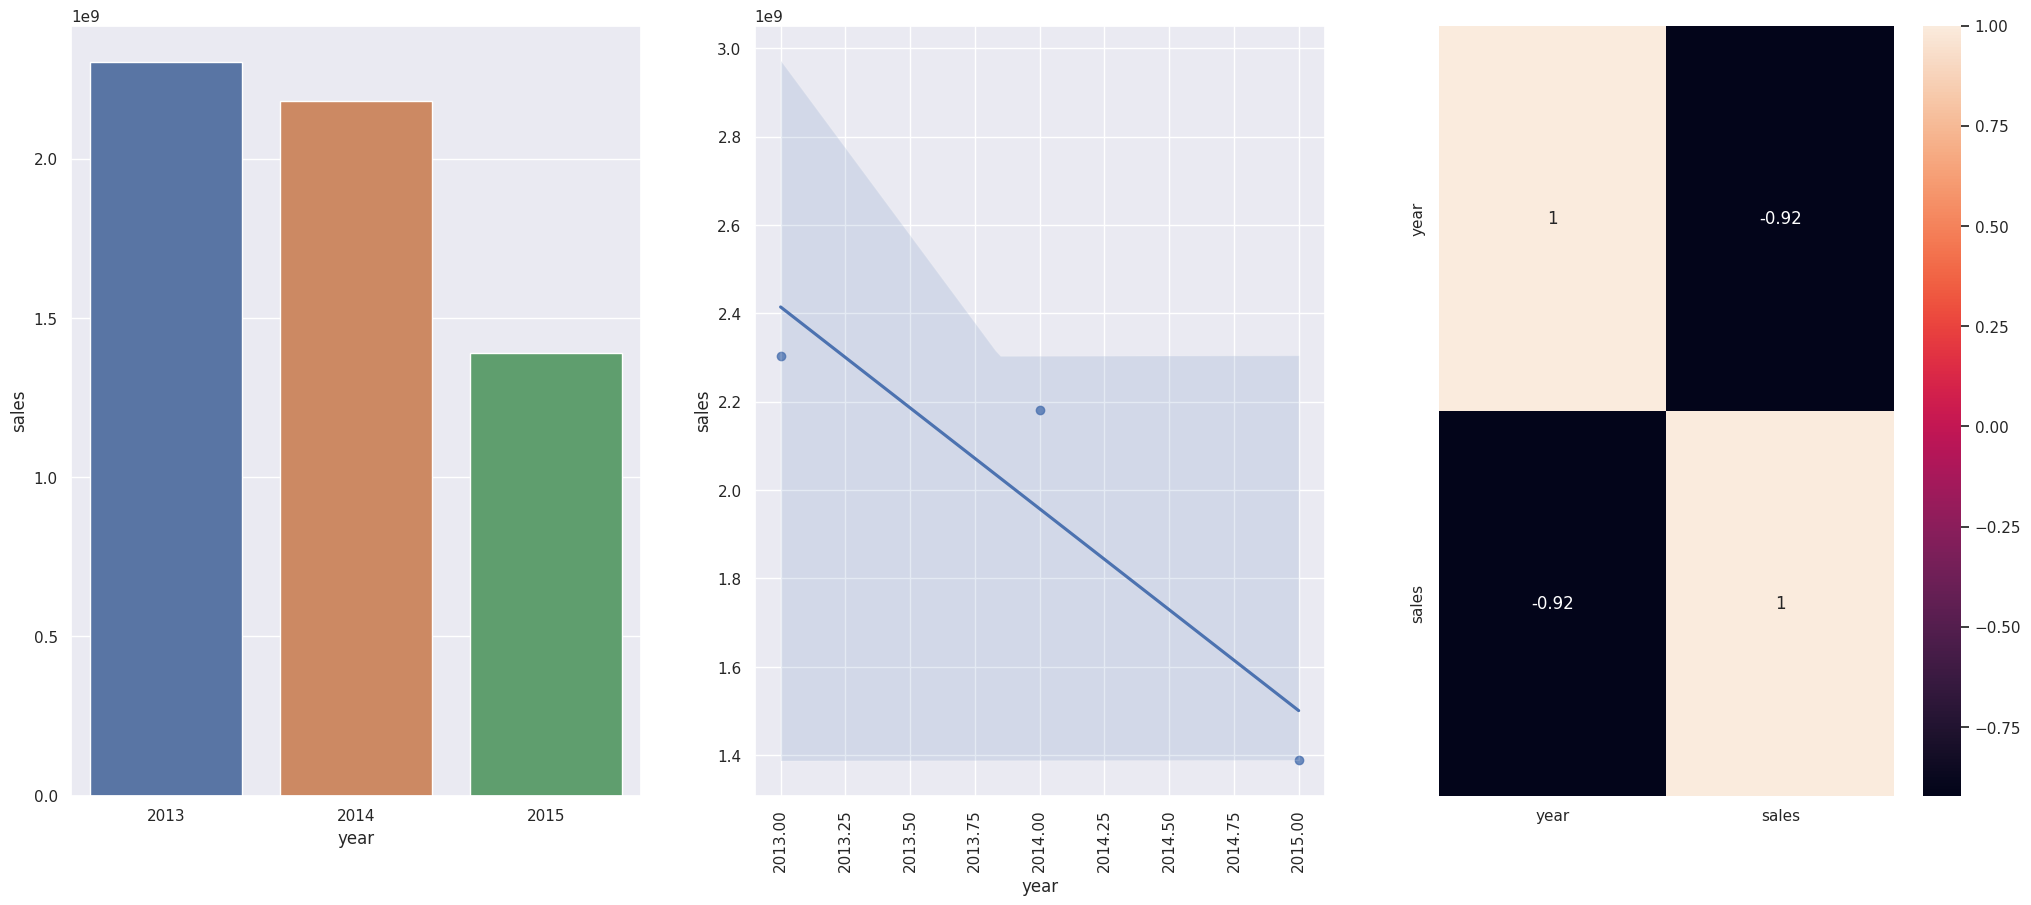

In [89]:
plt.subplot(1, 3, 1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.regplot(x='year', y='sales', data=aux1)
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### 8. Lojas vendem menos nos finais de semana?
-> A hipótese é VERDADEIRA. As lojas vendem MENOS nos finais de semana.

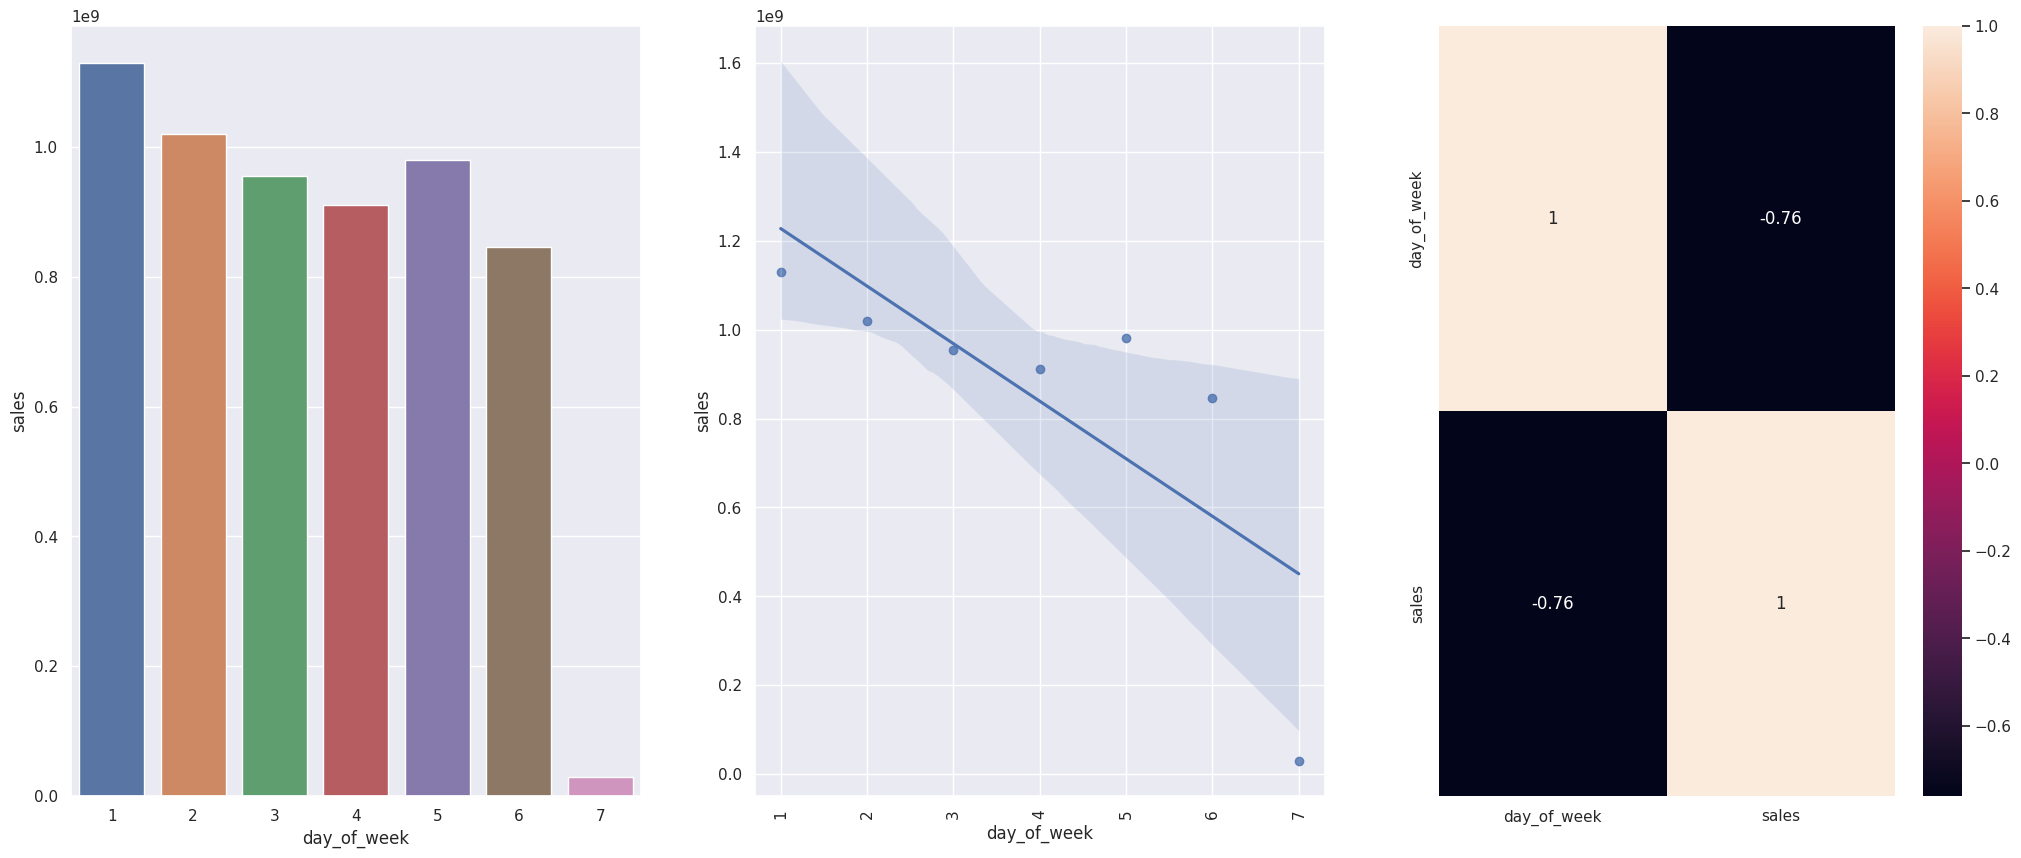

In [90]:
grid = GridSpec(1,3)

plt.subplot(grid[0,0])
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(grid[0,1])
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.regplot(x='day_of_week', y='sales', data=aux1)
plt.xticks(rotation=90);

plt.subplot(grid[0,2])
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### 9. Lojas vendem mais depois do 10º dia do mês?
-> A hipótese é VERDADEIRA. As lojas vendem MAIS depois do 10º do mês.

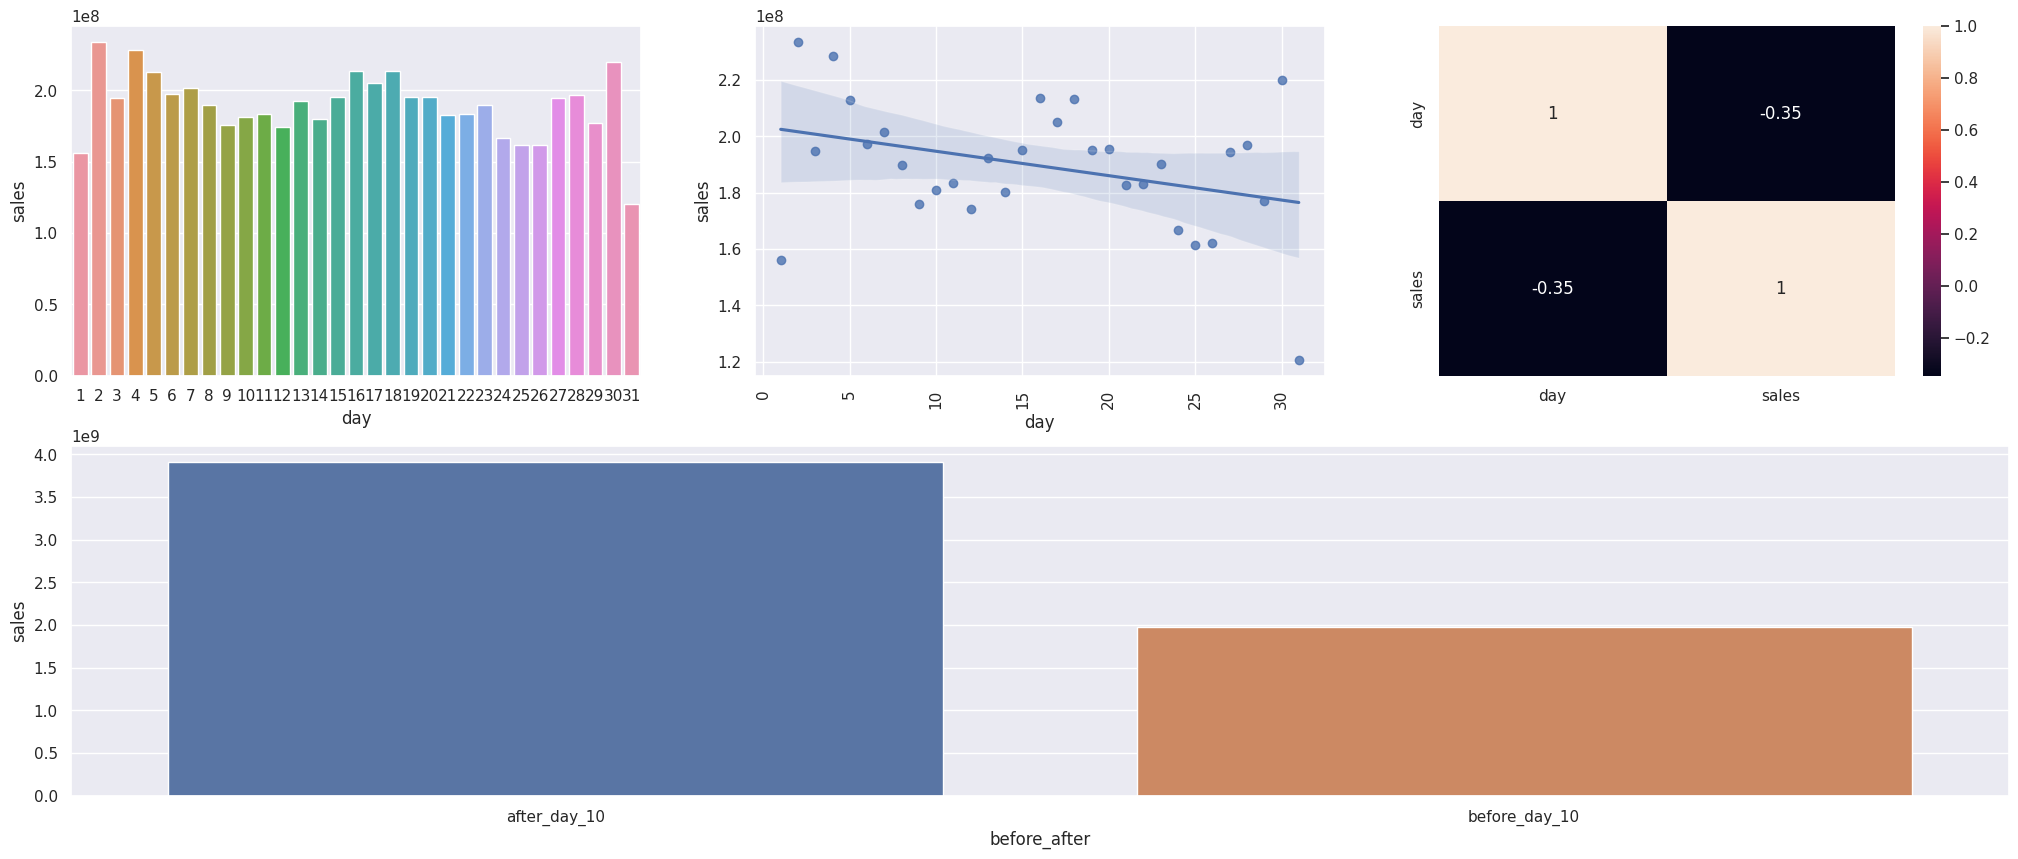

In [91]:
grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(grid[0,1])
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.regplot(x='day', y='sales', data=aux1)
plt.xticks(rotation=90)

plt.subplot(grid[0,2])
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(grid[1,:])
sns.barplot(x='before_after', y='sales', data=aux2);

##### Resumo da checagem de Hipóteses

In [92]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', 'Falsa', 'Baixa'],
['H6', 'Falsa', 'Media'],
['H7', 'Falsa', 'Alta'],
['H8', 'Verdadeira', 'Alta'],
['H9', 'Verdadeira', 'Alta']]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           Falsa        Baixa
H6           Falsa        Media
H7           Falsa        Alta
H8           Verdadeira   Alta
H9           Verdadeira   Alta


#### 4.3 Multivariate Analysis

##### 4.3.1 Numerical Attributes

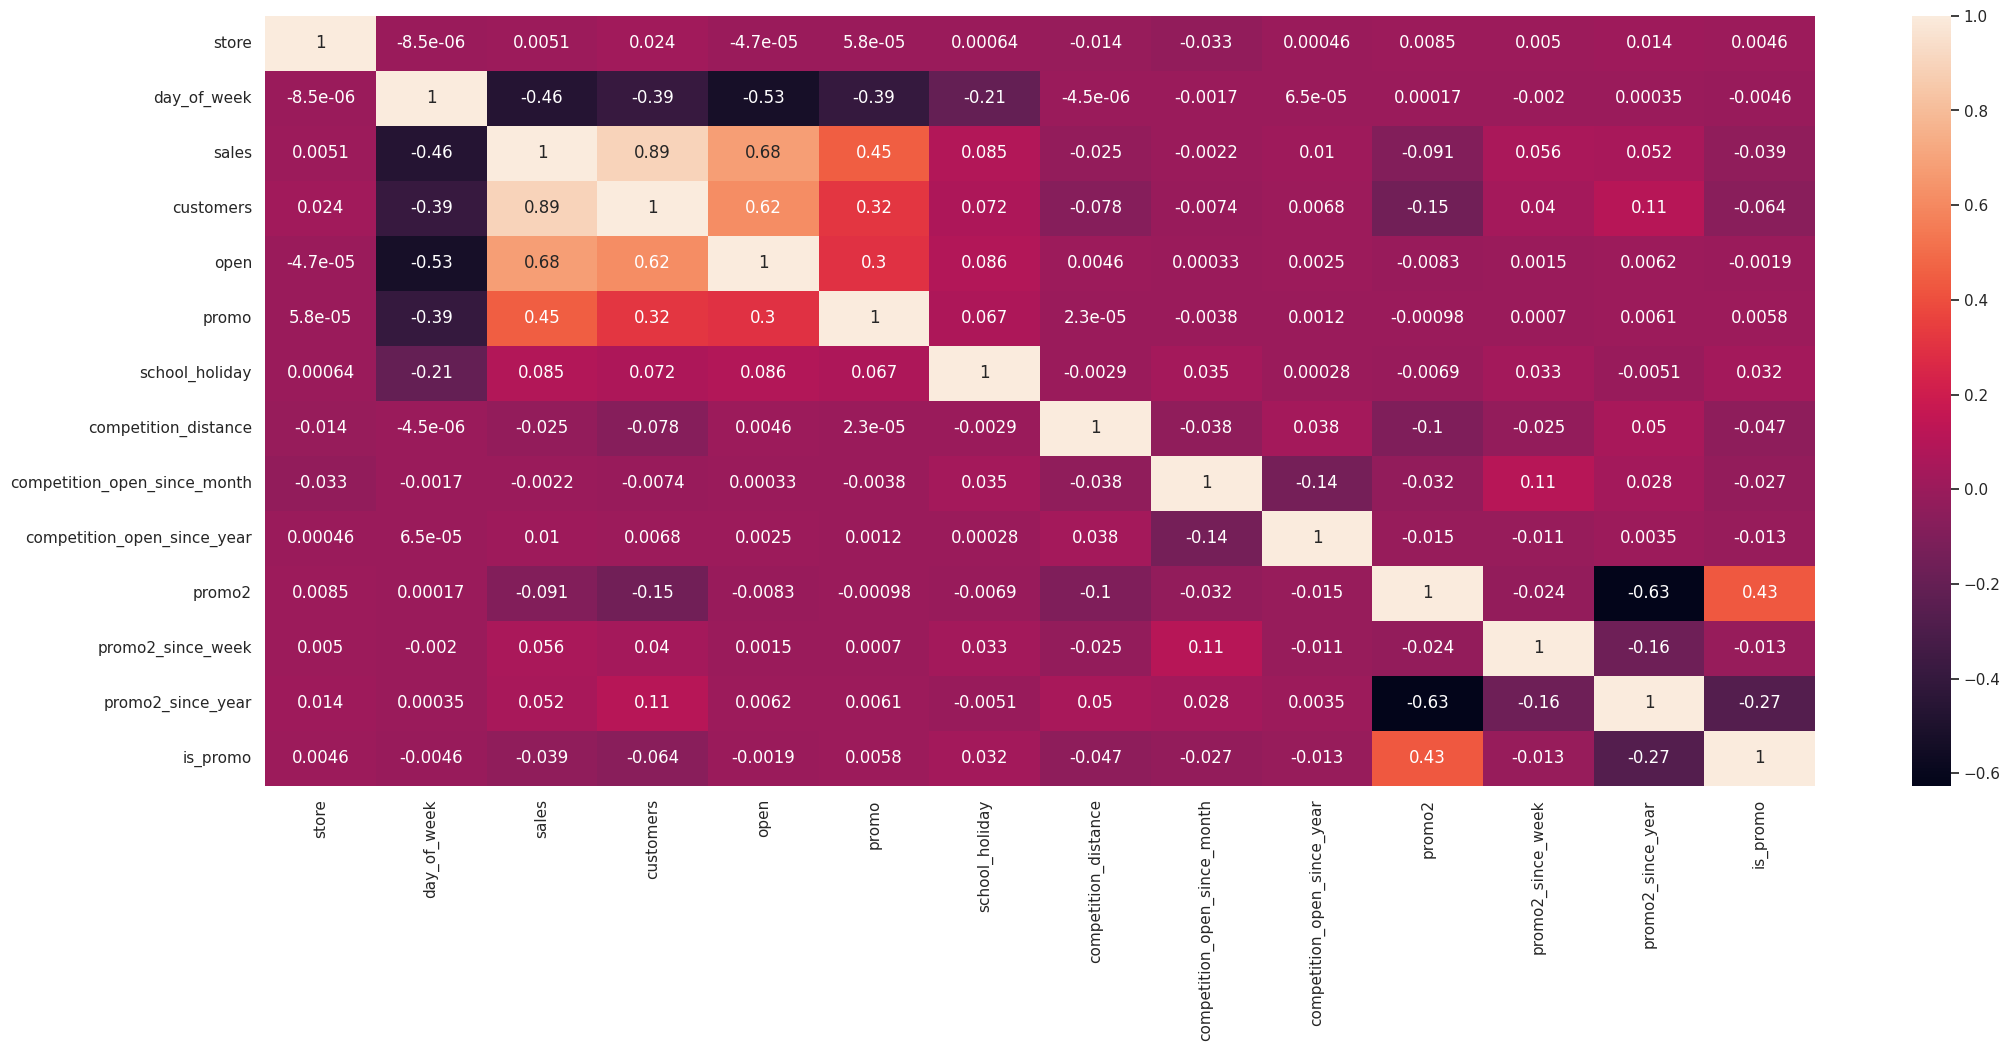

In [93]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

##### 4.3.2 Categorical Attributes

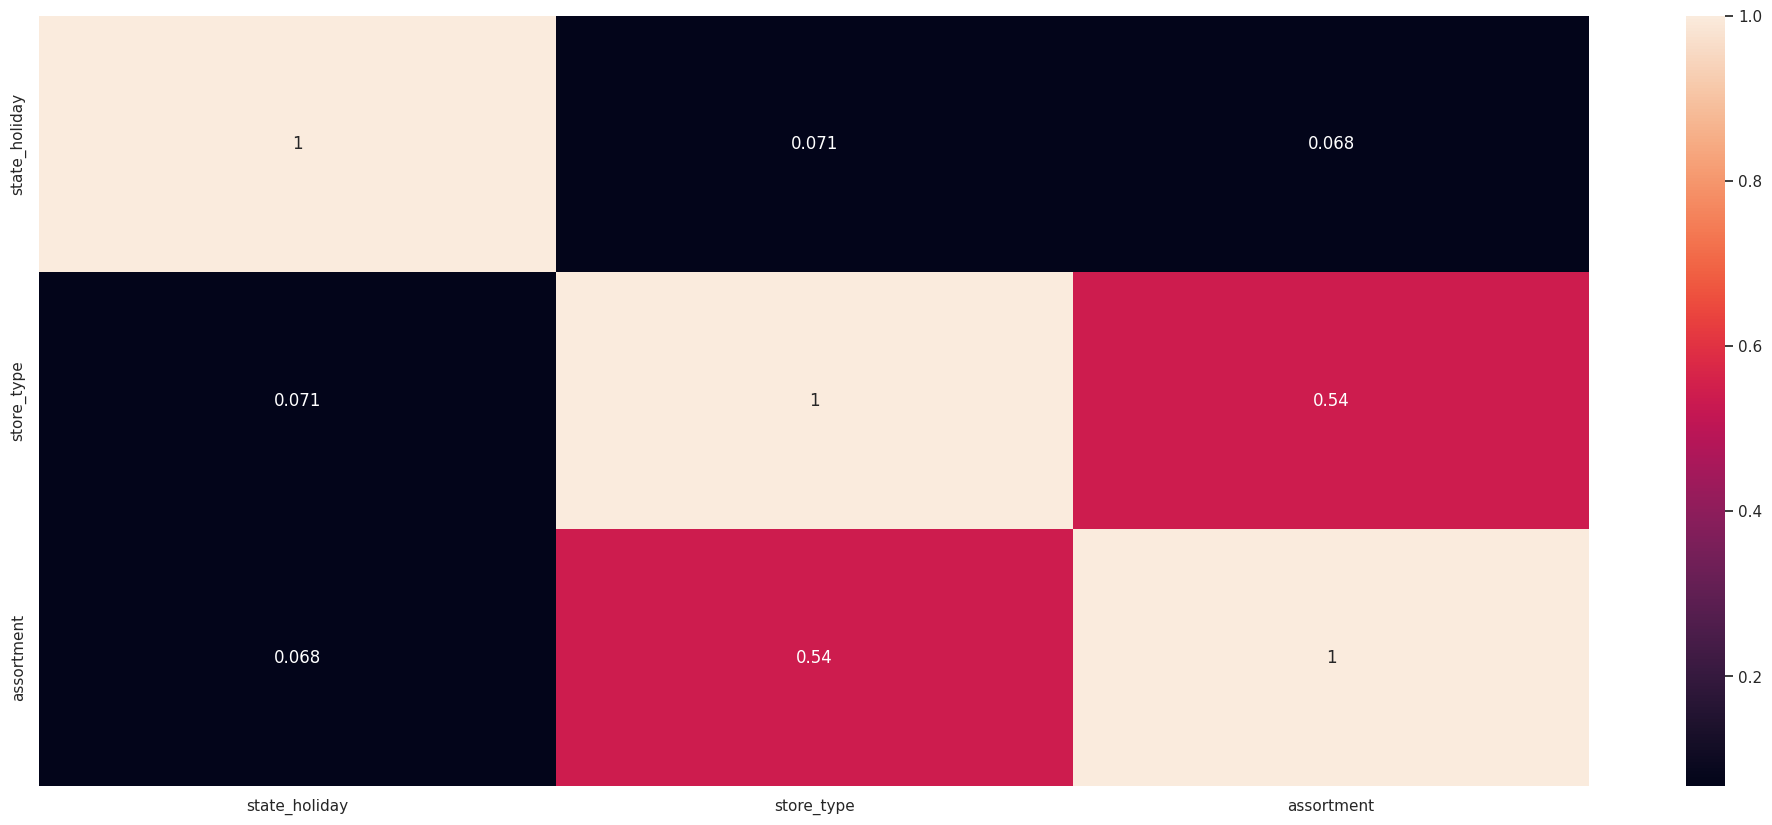

In [94]:
# Separação dos valores categóricos
aux = df4.select_dtypes(include='object')

# Aplicação da correlação categórica de Cramer's V
aux1 = cramers_v(aux['state_holiday'], aux['state_holiday'])
aux2 = cramers_v(aux['state_holiday'], aux['store_type'])
aux3 = cramers_v(aux['state_holiday'], aux['assortment'])

aux4 = cramers_v(aux['store_type'], aux['state_holiday'])
aux5 = cramers_v(aux['store_type'], aux['store_type'])
aux6 = cramers_v(aux['store_type'], aux['assortment'])

aux7 = cramers_v(aux['assortment'], aux['state_holiday'])
aux8 = cramers_v(aux['assortment'], aux['store_type'])
aux9 = cramers_v(aux['assortment'], aux['assortment'])

aux10 = pd.DataFrame({'state_holiday': [aux1, aux2, aux3],
                      'store_type': [aux4, aux5, aux6], 
                      'assortment': [aux7, aux8, aux9]})

aux10 = aux10.set_index(aux10.columns)

sns.heatmap(aux10, annot=True);

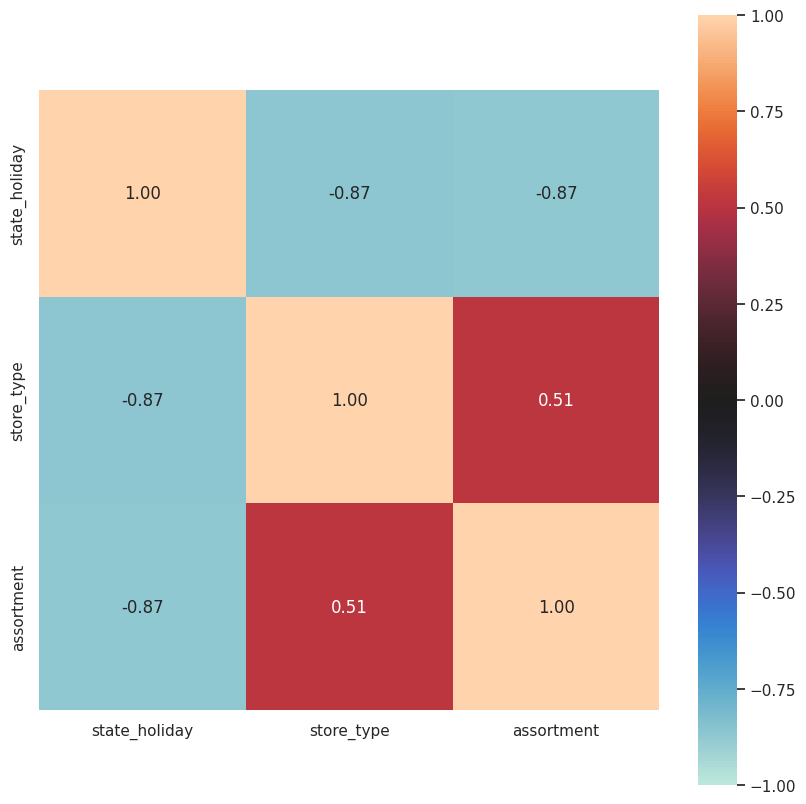

In [95]:
# Aplicação da correlação categórica de Theil's U (uncertainty coefficient)
associations(aux10, nom_nom_assoc='theil', figsize=(10,10));

### 5.0 Data Preparation for ML

In [145]:
df5 = df4.copy()

#### 5.1 Normalization

In [146]:
# Não há atributos para normalizar

#### 5.2 Rescaling

In [147]:
aux = df5.select_dtypes(include=['int64', 'float64'])

# ajuste da coluna 'competition_distance' -> RobustScaler
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# ajuste da coluna 'competition_time_month' -> RobustScaler
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# ajuste da coluna 'promo_time_week' -> MinMaxScaler
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# ajuste da coluna 'year' -> MinMaxScaler
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

#### 5.3 Transformation

##### 5.3.1 Encoding

In [148]:
# transformação dos conteúdos 'object' para 'int64' -> One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# transformção dos conteúdos 'object' para 'int64' -> Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# transformação dos conteúdos 'object' para 'int64' -> Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

##### 5.3.2 Response Variable Transformation

In [149]:
# Conversão do valores da coluna sales de valores para o logaritmo -> que é o valor oposto da exponenciação, ex: 10**3 = 1000 == log10 = 3  
df5['sales'] = np.log1p(df5['sales'])

##### 5.3.3 Nature Transformation

In [150]:
# ajuste dos períodos de tempo dos dias do mês, dias da semana, semanas e meses para valores cíclicos utilizando as fórmulas de seno e coseno
# colunas dos dias da semana
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

# dias do mês
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

# semanas
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

# meses
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

### 6.0 Feature Selection

In [151]:
df6 = df5.copy()

##### 6.1 Spliting dateframe for test and training

In [103]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [104]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [105]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Min Date: {}'.format(X_train['date'].max()))

print('\nTraining Min Date: {}'.format(X_test['date'].min()))
print('Training Min Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Min Date: 2015-06-18 00:00:00

Training Min Date: 2015-06-19 00:00:00
Training Min Date: 2015-07-31 00:00:00


##### 6.2 Boruta as Feature Selector

In [106]:
# training and test dataset for Boruta
x_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# # defining RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

##### 6.2.1 Best Features from Boruta

In [107]:
# cols_selected = boruta.support_.tolist()

# # best features
# x_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected for boruta
# cols_not_selected_boruta = np.setdiff1d(x_train_fs.columns, cols_selected_boruta)

##### 6.3 Manual Feature Selection

In [108]:
# Foi adicionada manualmente a coluna 'month_sin' que havia sido excluída pelo Boruta
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'day_sin',
                        'day_cos',
                        'month_sin',
                        'month_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

### Desativados para poder apontar os resultados dos algoritmos
# final features
#cols_selected_boruta.extend(feat_to_add)

# Definindo as colunas para poder realizar a Cross Validation
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

### 7.0 Machine Learning Modelling

In [109]:
# Separação dos conjunto de dados para executar os algoritmos de ML
x_train = X_train[cols_selected_boruta]
x_training = X_train[cols_selected_boruta_full]
x_test = X_test[cols_selected_boruta]

##### 7.1 Average Model

In [110]:
# aux1 = x_test.copy()
# aux1['sales'] = y_test.copy()

# # prediction
# aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
# aux1 = pd.merge(aux1, aux2, how='left', on='store')
# yhat_baseline = aux1['predictions']

# # performance
# baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))

##### 7.2 Linear Regression Model

In [111]:
# # model
# lr = LinearRegression().fit(x_train, y_train)

# # prediction
# yhat_lr = lr.predict(x_test)

# # performance
# lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))

##### 7.2.1 Linear Regression Model - Cross Validation

In [112]:
# lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False )

##### 7.3 Linear Regression Regularized Model - Lasso Model

In [113]:
# # model
# lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# # prediction
# yhat_lrr = lrr.predict(x_test)

# # performance
# lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))

##### 7.3.1 Lasso - Cross Validation

In [114]:
# lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression Regularized', lrr, verbose=False )

##### 7.4 Random Forest Regressor

In [115]:
# # model
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# # prediction
# yhat_rf = rf.predict(x_test)

# # performance
# rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))

##### 7.4.1 Random Forest Regressor - Cross Validation

In [116]:
# rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)

##### 7.5 XGBoost Regressor

In [117]:
# # model
# model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                              n_estimators=128,
#                              eta=0.3,
#                              max_depth=6,
#                              subsample=1).fit(x_train, y_train)

# # prediction
# yhat_xgb = model_xgb.predict(x_test)

# # performance
# xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))

##### 7.5.1 XGBoost Regressor - Cross Validation

In [118]:
# xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)

##### 7.6 Comparing Model's Performance

In [119]:
# modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
# modelling_result.sort_values('RMSE')

##### 7.6.1 Comparing Model's Performance - Cross Validation


In [120]:
# modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
# modelling_result_cv.sort_values('RMSE CV')

### 8.0 Hyperparameter Fine Tuning

##### 8.1 Random Search

In [121]:
param = {'n_estimators': [128, 256, 512],
         'eta': [0.01, 0.03, 0.3],
         'max_depth': [3, 5, 6, 9],
         'subsample': [0.1, 0.5, 0.7, 1],
         'colsample_bytree': [0.3, 0.7, 0.9, 1]}

iterations = 5

In [122]:
# final_result = pd.DataFrame()

# for x in range (iterations):
#     # choose values for parameters randomly
#     hp = {y: random.sample(v, 1)[0] for y, v in param.items()}
#     print(hp)

#     # model 
#     model_xgb = xgb.XGBRegressor(objective= 'reg:squarederror',
#                                  n_estimators= hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'])

#     # performance
#     result = cross_validation(x_training, 3, 'XGBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat([final_result, result])

# final_result

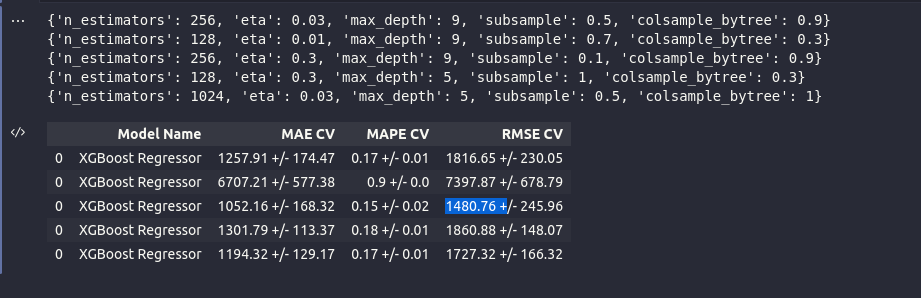

In [123]:
Image('img/Random Search.png')

##### 8.2 Final Model

In [124]:
param_tuned = {'n_estimators': 3000,
               'eta':0.03 ,
               'max_depth': 5,
               'subsample': 0.7,
               'colsample_bytree': 0.7}

In [125]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective= 'reg:squarederror',
                                   n_estimators= param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree']).fit(x_train, y_train)

# predict
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))

In [126]:
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,764.220075,0.11502,1095.112903


In [127]:
# pickle.dump(xgb_result_tuned, open('model_dump/model_rossman.pkl', 'wb'))

In [128]:
# with open('model_dump/model_rossman.pkl', 'rb') as data_dumped:
#     pickle_dumped = pickle.load(data_dumped)

# pickle_dumped

### 9.0 Errors Interpretation

In [129]:
# Montando a base de dados para a nova etapa
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

##### 9.1 Business Performance

In [130]:
# soma das predições
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()


# Erros: MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Agrupando
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Previsões
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Reordenando
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

##### 9.1 Total Performance

In [131]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$286,777,280.00"
1,worst_scenario,"R$285,922,025.59"
2,best_scenario,"R$287,632,513.41"


##### 9.1 Machine Learning Performance


In [132]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

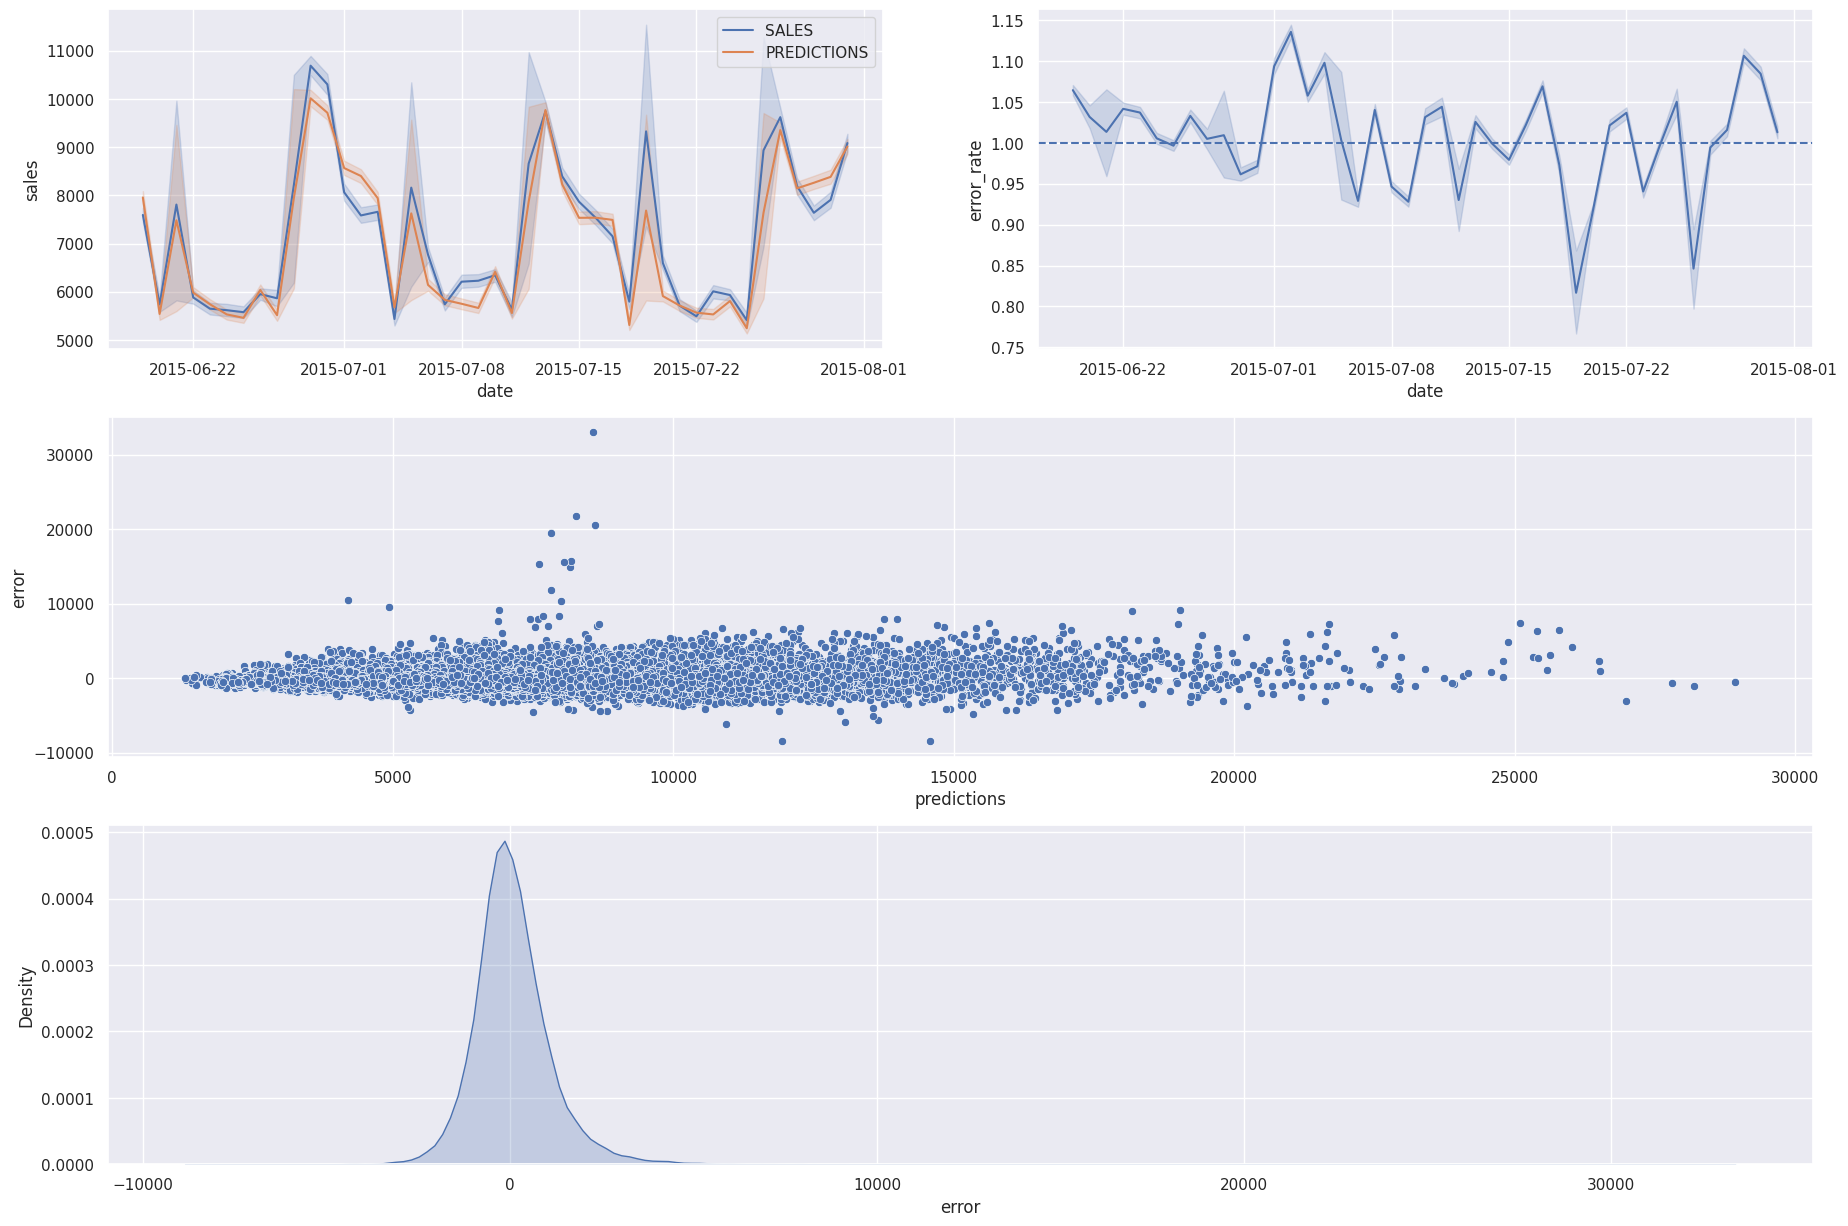

In [133]:
plt.rcParams['figure.figsize']=(22, 15);
grid = GridSpec(3,2)

plt.subplot(grid[0,0])
sns.lineplot(x='date', y='sales', data=df9, label='SALES');
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS');

plt.subplot(grid[0,1])
sns.lineplot(x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--')

plt.subplot(grid[1,:])
sns.scatterplot(data=df9, x='predictions', y='error');

plt.subplot(grid[2,:])
sns.kdeplot(df9['error'], fill=True, palette='magma');

### 10.0 Production Model

In [ ]:
# Salvando o modelo treinado
pickle.dump(model_xgb_tuned, open('model/model_rossmann.pkl', 'wb'))

##### 10.1 Rossman Class 

In [ ]:
class Rossmann(object):
    def __init__(self):
        self.competition_time_month_scaler = pickle.load(open('parameter/competition_time_month_scaler.pkl', 'rb'))
        self.competition_distance_scaler   = pickle.load(open('parameter/competition_distance_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open('parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open('parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open('parameter/store_type_scaler.pkl', 'rb'))

    def data_cleaning(self, df1):
        
        # 1.1 Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))
        df1.columns = cols_new
        
        # 1.3 Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        #competition_distance -> filling the dataset with a high distance value
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        # 1.6 Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        return df1
    
    def feature_engineering(self, df2):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1), axis=1)    
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)
                
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days= 7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.1 Row Filtering
        df2 = df2[(['open'] != 0) & (df2['sales'] > 0)]
        
        # 3.2 Column Filtering
        cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)

        return df2
    
    def data_preparation (self, df5):

        # Rescaling
        # ajuste da coluna 'competition_distance' -> RobustScaler
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        
        # ajuste da coluna 'competition_time_month' -> RobustScaler
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        
        # ajuste da coluna 'promo_time_week' -> MinMaxScaler
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        # ajuste da coluna 'year' -> MinMaxScaler
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
        
        # transformação dos conteúdos 'object' para 'int64' -> One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # transformção dos conteúdos 'object' para 'int64' -> Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
        
        # transformação dos conteúdos 'object' para 'int64' -> Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        # 5.3.3 Nature Transformation
        # ajuste dos períodos de tempo dos dias do mês, dias da semana, semanas e meses para valores cíclicos utilizando as fórmulas de seno e coseno
        # colunas dos dias da semana
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

        # dias do mês
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

        # semanas
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

        # meses
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

        # Foi adicionada manualmente a coluna 'month_sin' que havia sido excluída pelo Boruta
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                         'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                         'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
                         'week_of_year_sin', 'week_of_year_cos']

        return df5[cols_selected]   

##### 10.2 API Handler

In [ ]:
import pandas as pd
from flask import Flask, Response, request
from rossmann.Rossmann import Rossmann
# Loading model
model = pickle.load(open('model/model_rossman.pkl', 'rb'))

# Initialize API
app = Flask(__name__)

@app.route('rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()

    if test_json: # checking data
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])

        else: # multiple examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instantiate Rossmann class
        pipeline = Rossmann()

        # Data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # Feature Engineering
        df2 = pipeline.feature_engineering(df1)

        # Data Preparation
        df3 = pipeline.data_preparation(df2)

        # Prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response

    else:
        return Response('{}', status=200, mimetype='application/json')


if __name__ == '__main__':
    app.run('0.0.0.0')

##### 10.3 API Tester